# George_CALC_Fig2


A notebook to make Fig.2 with George, using only MAP, Jeff1 or Jeff2 priors. See if we get the same as Celerite ... (we ought ! )

In [1]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import modules as mod
import imp
imp.reload(mod)

<module 'modules' from '/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py'>

First, show that implementation of George fitting in modules.py  actually works ... 

input (DRW  units):  tau=  10  sigma=  0.141421356237
input (George units): log(a)  =  -3.91202300543 log(M_00)=log(l^2)= 4.60517018599
Initial params: [-3.91202301  4.60517019]
sig_lims: [0.01, 1.0] tau_lims: [1, 10000]
bounds for fitted params are  [(-9.2103403719761818, 0.0), (0.0, 18.420680743952367)]
for params  odict_keys(['kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0'])
      fun: -542.67437114331574
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   1.13686838e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 10
   status: 0
  success: True
        x: array([-3.90113897,  9.2781755 ])
sigma_fit= 0.142193071582 tau_fit= 103.449932423


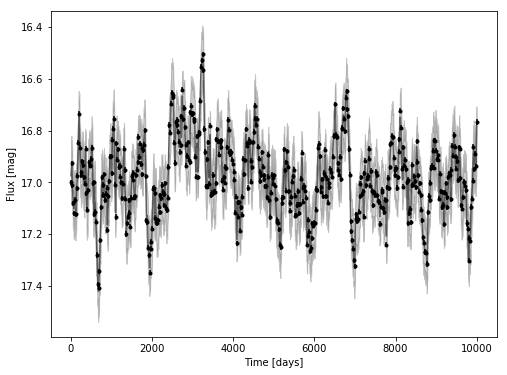

In [69]:
%matplotlib inline
t = np.linspace(0,10000,500)
SFinf  = 0.2 
tau_in= 10
sigma_in= SFinf / np.sqrt(2)
y  = mod.sim_DRW_lightcurve(t,SFinf,tau,17)
yerr = 0.01
yobs = y + yerr * np.random.normal(loc=0,scale=1, size=len(y))

#plt.errorbar(t,yobs, yerr)
sigma_input = SFinf / np.sqrt(2)
print('input (DRW  units):  tau= ', tau_in, ' sigma= ', sigma_in)
print('input (George units): log(a)  = ', np.log(sigma_in**2.0), 
     'log(M_00)=log(l^2)=', np.log(tau_in**2.0))

prior='None'
sig_lims=[0.01, 1.0 ]
tau_lims = [1,10000]
sigma0 = sigma_in
tau0 = tau_in
sigma_fit, tau_fit,gp  = mod.find_george_MAP(t,y,yerr, sigma0, tau0,
                                    prior=prior,set_bounds=True , sig_lims=sig_lims  , 
                                    tau_lims=tau_lims ,verbose=True)


#print('sigma_fit=', sigma_fit,  'tau_fit=', tau_fit)

# plot the new prediction
x_pred = np.linspace(min(t),max(t), 1500)
pred, pred_var = gp.predict(yobs, x_pred, return_var=True)

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.fill_between(x_pred, pred - 3*np.sqrt(pred_var), pred + 3*np.sqrt(pred_var),
                color="k", alpha=0.2)
ax.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
ax.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
ax.invert_yaxis()
ax.set_xlabel('Time [days]')
ax.set_ylabel('Flux [mag]')


Now, use it as follows , calculating on the new light curves (from 18/07/13) 

In [8]:
import os
# span the rho grid ...
t_exp = 8 * 365.0 # in days 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

simulation = 'OGLE'
if simulation is 'SDSS' : 
    r = 17 # mag 
    variance = 0.013**2.0 + np.exp(2 * (r-23.36))
    t = np.loadtxt('t_SDSS_NEW.txt')
    
if simulation is 'OGLE':
    N = 445 
    I = 18 # mag 
    variance = 0.004**2.0 + np.exp(1.63 * (I - 22.55))    
    t =  np.loadtxt('t_OGLE_NEW.txt')
print(simulation,' noise stdev ', np.sqrt(variance))

# set the light curve directory 
lcDir = '../data_products/Simulated_DRW_Kozlowski/'+\
         simulation+'/180713_light_curves_NEW/'

# set the output directory & make it if it doesn't exist ....  
resDir  = '../data_products/Simulated_DRW_Kozlowski/'+\
         simulation+'/190208_George_MAP/'
if not os.path.exists(resDir):
    os.makedirs(resDir)
    
# set the limits :  beyond the input tau, which 
# go from 2.91 days, to 43 800 days  ( for the rho_grid running 
# from 0.001 to 15,  and the experiment length equal to 8 * 365 days )

sig_lims = [0.01, 1.0]  ; tau_lims = [1,45000]
verbose = False
expectation = False 
sigma0 = 0.2  # initializing values for the kernel ... 
tau0 = 100 
# read in the light curves
rho_ind = np.arange(len(rho_grid))
for i in rho_ind: # range(len(rho_grid)):#: 
    
    # just for initializing the celerite kernel - 
    # doesn't have to be even close to the true value .
    rho_in = rho_grid[i]
    tau_in = rho_in * t_exp
    if verbose:
        print('tau_in = ', tau_in)
    # for each rho, read in  N light curves 
    # N = 100 
    for j in range(100):#100): 
        fname = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
        
        # load the ideal lc , made with mod.sim_DRW_lightcurve()
        y = np.loadtxt(lcDir+fname)
        # add noise 
        noise = np.random.normal(loc=0,scale=np.sqrt(variance),size=len(t))
        y += noise +10 # eq.2 Kozlowski+2017
        yerr = np.ones_like(t)* np.sqrt(variance)
        
        results = {}
        # define which priors we would like to try ... 
        
        for prior in [ 'Jeff1', 'Jeff2']:
            results[prior] = {}

            # MAP estimate        
            sigmaMAP, tauMAP,gp = mod.find_george_MAP(t,y,yerr, sigma0, tau0,
                                    prior=prior,set_bounds=True , sig_lims=sig_lims  , 
                                    tau_lims=tau_lims ,verbose=verbose)
            
            
            # store results from MAP  and input 
            results[prior]['sigma_MAP'] = sigmaMAP
            results[prior]['tau_MAP'] = tauMAP
            results[prior]['rho_in'] = rho_in
            results[prior]['tau_in'] = tau_in

            if expectation : 
                # expectation from grid  
                Ngrid = 60  ; scale = 'log'
                sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
                logP = mod.evaluate_logP(sigma_grid, tau_grid,y,gp,prior,'george')

                # store the initial sigma grid and log Posterior 
                results[prior]['logPosterior'] = logP
                results[prior]['sigma_grid'] = sigma_grid
                results[prior]['tau_grid'] = tau_grid

                # find the expectation value 
                sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                                    tau_grid, verbose)
                results[prior]['sigma_EXP'] = sigmaEXP
                results[prior]['tau_EXP'] = tauEXP
            
        # save in  a file ...
        name = fname[:-4]+'_logP.npy'
        np.save(resDir  + name, results)
        if j % 10 == 0 :  # only print every tenth .... 
            print(simulation, ' Saved logP (and MAP) dic as %s'%name)

        

OGLE  noise stdev  0.0248445133097
OGLE  Saved logP (and MAP) dic as DRW_rho-000_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-000_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-001_050_logP.npy
OGLE  Saved logP (and

OGLE  Saved logP (and MAP) dic as DRW_rho-013_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-014_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-015_050_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-027_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-027_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-028_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-029_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-029_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-029_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-029_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-029_040_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-041_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-041_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-041_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-042_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-043_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-043_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-043_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-043_030_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-055_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-055_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-055_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-055_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-056_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-057_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-057_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-057_020_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-069_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-069_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-069_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-069_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-069_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-070_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-071_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-071_010_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-083_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-083_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-083_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-083_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-083_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-083_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-084_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-085_000_logP.n

OGLE  Saved logP (and MAP) dic as DRW_rho-097_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-097_090_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_000_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_010_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_020_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_030_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_040_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_050_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_060_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_070_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_080_logP.npy
OGLE  Saved logP (and MAP) dic as DRW_rho-098_090_logP.n